In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### Importing and Cleaning for Crime Data

In [ ]:
# Importing Dataframes
crimes = pd.read_csv(
    'data/crimes_combined.csv',
    index_col=0,
    dtype={
        'beat': 'Int64',
        'community_area': str,
        'fbi_code': str,
    },
    low_memory=False,
)
codes = pd.read_csv('data/IUCR_Codes.csv', index_col=0)

In [ ]:
crimes['date'] = pd.to_datetime(crimes['date'])
crimes['domestic'] = crimes['domestic'].astype(str).str.lower()
crimes['domestic'] = crimes['domestic'].apply(lambda x: True if x != 'false' else False)

crimes.sort_values(by='date', ascending=False, inplace=True)

In [ ]:
# Removing leading zeros from IUCR codes because of mistmatch between the two datasets.
codes.index = codes.index.str.lstrip('0')
crimes['iucr'] = crimes['iucr'].str.lstrip('0')

In [ ]:
print(crimes.columns)
print(codes.columns)

print(crimes.shape)
print(codes.shape)

print(crimes.dtypes)
print(codes.dtypes)

In [ ]:
# Joining crimes and IUCR codes datasets
joined = crimes.join(other=codes[['PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION']], on='iucr', how='left')

In [ ]:
print(joined.shape)
joined.head()

In [ ]:
# Merging duplicated names for primary types columns.

def clean_crime_types(type: str) -> str:
    output = None
    if type == 'CRIM SEXUAL ASSAULT':
        output = 'CRIMINAL SEXUAL ASSAULT'
    elif type in ['NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)']:
        output = 'NON-CRIMINAL'
    else:
        output = type
    return output

joined['primary_type'] = joined['primary_type'].apply(clean_crime_types)

In [ ]:
# The data for the first few years is very sparse and includes much fewer observations. We remove these.
print(joined['date'].dt.year.value_counts().sort_index())
joined = joined[joined['date'].dt.year > 2004]

### Importing and Cleaning Weather Data

In [ ]:
weather = pd.read_csv('data/weather_data.csv', low_memory=False)

In [ ]:
weather.columns = [column.lower() for column in weather.columns]
weather['date'] = pd.to_datetime(weather['date'])

weather.sort_values(by='date', ascending=False, inplace=True)

In [ ]:
weather.dtypes

In [ ]:
metric_columns = weather.columns[:13].drop(['station', 'date', 'name', 'tsun'])

In [ ]:
across_stations = weather.groupby(by='date')[metric_columns].agg('mean')
across_stations.reset_index(inplace=True)

### Basic Visualizations

In [ ]:
period = across_stations.groupby(across_stations['date'].dt.to_period('M'))[
    ['awnd', 'fmtm', 'pgtm', 'prcp', 'snow', 'snwd', 'tavg', 'tmax', 'tmin']
]

monthly = across_stations.groupby(across_stations['date'].dt.month)[
    ['awnd', 'fmtm', 'pgtm', 'prcp', 'snow', 'snwd', 'tavg', 'tmax', 'tmin']
]

period_averages = period.agg('mean').reset_index(names='period')
period_totals = period.agg('sum').reset_index(names='period')
monthly_averages = monthly.agg('mean').reset_index(names='month')

In [ ]:
month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

plt.figure(figsize=(8, 8))
axes = plt.gca()

axes.bar(
    monthly_averages["month"].astype(str), monthly_averages["tavg"], color="skyblue"
)

axes.set_title("Temperature bar Month")
axes.set_xlabel("Month of Year")
axes.set_ylabel("Temperature in F")
axes.set_xticks(monthly_averages["month"]-1)
axes.set_xticklabels(month_names)

# for l, s in axes.spines.items():
#     if l == 'left':
#         s.set_label('Temperature in $f$')
#     if l == 'bottom':
#         s.set_label('Month of Year')

plt.show()

In [ ]:
# The column 'primary_type' is better than the foreign column 'primary description' because the latter has some NaN values but in all other cases (Except for shortened version of 'CRIMINAL SEXUAL ASSAULT') the values are exactly the same.

type_equal_mask = joined['primary_type'] == joined['PRIMARY DESCRIPTION']
not_equal = joined[~type_equal_mask]

not_equal[not_equal['PRIMARY DESCRIPTION'].notnull()]['PRIMARY DESCRIPTION'].unique()

In [ ]:
for tup in joined['arrest'].value_counts().items():
    print(f'Number of{" NOT " if tup[0] is False else " "}arrested: {tup[1]:,}')

In [115]:
joined.head()

,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,latitude,longitude,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION
id,,,,,,,,,,,,,,,,,,
13661388,JH505170,2024-11-10,022XX W CHICAGO AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,1212,12.0,36,24,11,41.895813,-87.682660,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300
13663112,JH507259,2024-11-10,079XX S DAMEN AVE,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,RESIDENCE,False,False,611,6.0,17,71,11,41.749744,-87.673117,DECEPTIVE PRACTICE,CREDIT CARD FRAUD
13658953,JH502179,2024-11-10,031XX W 39TH PL,486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,921,9.0,12,58,08B,41.821718,-87.702855,BATTERY,DOMESTIC BATTERY SIMPLE
13659384,JH502921,2024-11-10,093XX S WABASH AVE,820,THEFT,$500 AND UNDER,STREET,False,False,634,6.0,6,49,06,41.724619,-87.622284,THEFT,$500 AND UNDER
13659481,JH503036,2024-11-10,104XX S OGLESBY AVE,497,BATTERY,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS ...,STREET,False,True,434,4.0,7,51,04B,41.705489,-87.565680,BATTERY,AGGRAVATED DOMESTIC BATTERY - OTHER DANGEROUS ...


In [114]:
for tup in joined['primary_type'].value_counts().items():
    print(f'{tup[0]}: {tup[1]:,}')

THEFT: 1,784,665
BATTERY: 1,485,021
CRIMINAL DAMAGE: 924,293
NARCOTICS: 616,208
ASSAULT: 574,921
OTHER OFFENSE: 508,678
DECEPTIVE PRACTICE: 470,541
BURGLARY: 416,443
MOTOR VEHICLE THEFT: 412,355
ROBBERY: 314,414
CRIMINAL TRESPASS: 203,605
WEAPONS VIOLATION: 152,296
OFFENSE INVOLVING CHILDREN: 66,275
PUBLIC PEACE VIOLATION: 54,613
PROSTITUTION: 45,900
CRIMINAL SEXUAL ASSAULT: 43,009
SEX OFFENSE: 33,230
INTERFERENCE WITH PUBLIC OFFICER: 25,357
ARSON: 13,882
GAMBLING: 11,278
LIQUOR LAW VIOLATION: 11,203
HOMICIDE: 10,922
STALKING: 6,771
KIDNAPPING: 5,616
INTIMIDATION: 4,826
CONCEALED CARRY LICENSE VIOLATION: 2,339
OBSCENITY: 1,337
NON-CRIMINAL: 454
PUBLIC INDECENCY: 252
HUMAN TRAFFICKING: 184
OTHER NARCOTIC VIOLATION: 171
RITUALISM: 10


In [190]:
# Creating pivot table for counts across different types of crimes, 'primary_type'
# We can determine which crime types have the most amount of seasonality by obtaining CV.
pivot = joined.pivot_table(index=joined['date'].dt.month, columns='primary_type', aggfunc='size')
pivot['total'] = pivot.sum(axis=1, numeric_only=True)
pivot.loc['total'] = pivot.iloc[:12].sum(axis=0)
pivot.loc['cv'] = (pivot.iloc[:12].std(axis=0) / pivot.iloc[:12].mean(axis=0)).round(decimals=2)
# pivot.index.name = 'month'
# pivot.columns.name = None
pivot.columns = [col.lower() for col in pivot.columns]

transposed = pivot.transpose()
transposed.index.name = "primary_type"
transposed.columns.name = None
transposed.sort_values(by=["total", "cv"], ascending=False, inplace=True)
transposed
# print("Coefficinet of Variability (CV) for all the crime types are:\n")

# for i,v in pivot.loc['cv'].sort_values(ascending=False).items():
#     print("cv:", v, "total_count:", "{:,}".format(pivot.loc["total", i].astype(int)), "---", i)

,1,2,3,4,5,6,7,8,9,10,11,12,total,cv
primary_type,,,,,,,,,,,,,,
total,643098.0,563688.0,675375.0,655658.0,722557.0,725166.0,754013.0,754607.0,722017.0,726340.0,643573.0,614977.0,8201069.0,0.09
theft,135979.0,116620.0,137891.0,136666.0,150530.0,158835.0,170932.0,172369.0,160892.0,162140.0,142871.0,138940.0,1784665.0,0.11
battery,107135.0,99626.0,125879.0,122207.0,141681.0,141343.0,141521.0,136012.0,131109.0,126633.0,108312.0,103563.0,1485021.0,0.13
criminal damage,66805.0,58299.0,75908.0,76877.0,83386.0,82748.0,87176.0,86370.0,81175.0,84782.0,74496.0,66271.0,924293.0,0.12
narcotics,53419.0,51792.0,58259.0,51306.0,52045.0,48481.0,51115.0,53511.0,52375.0,51223.0,49092.0,43590.0,616208.0,0.07
assault,40570.0,38781.0,48323.0,47593.0,55027.0,54257.0,54312.0,53053.0,52504.0,49802.0,41513.0,39186.0,574921.0,0.13
other offense,43408.0,40177.0,45965.0,43759.0,45519.0,43611.0,44325.0,43429.0,40754.0,42570.0,38303.0,36858.0,508678.0,0.07
deceptive practice,43395.0,36443.0,41272.0,38318.0,37603.0,38928.0,38799.0,39359.0,38122.0,40373.0,37401.0,40528.0,470541.0,0.05
burglary,32622.0,25491.0,29611.0,30314.0,35941.0,34967.0,37774.0,40127.0,38243.0,39657.0,36465.0,35231.0,416443.0,0.13


[Text(1, 0, 'Jan'),
 Text(2, 0, 'Feb'),
 Text(3, 0, 'Mar'),
 Text(4, 0, 'Apr'),
 Text(5, 0, 'May'),
 Text(6, 0, 'Jun'),
 Text(7, 0, 'Jul'),
 Text(8, 0, 'Aug'),
 Text(9, 0, 'Sep'),
 Text(10, 0, 'Oct'),
 Text(11, 0, 'Nov'),
 Text(12, 0, 'Dec')]

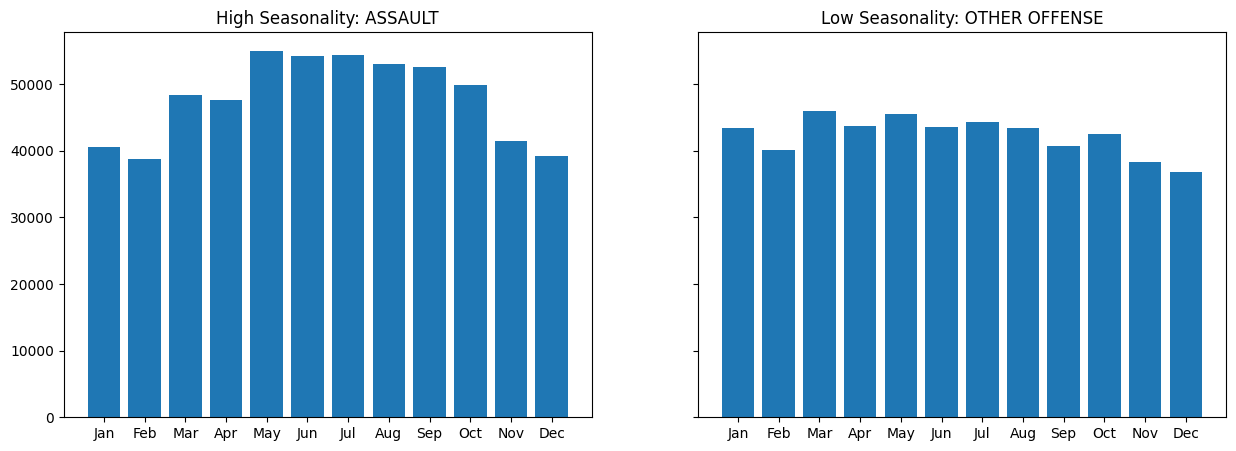

In [199]:
# Plotting an example of high vs low seasonality crime.

high_seasonality_crime = "ASSAULT"
low_seasonality_crime = "OTHER OFFENSE"

high_seasonality_counts = joined[joined["primary_type"] == high_seasonality_crime][
    "date"
].dt.month.value_counts()

low_seasonality_counts = joined[joined["primary_type"] == low_seasonality_crime][
    "date"
].dt.month.value_counts()

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)

ax1.bar(high_seasonality_counts.index, high_seasonality_counts)
ax2.bar(low_seasonality_counts.index, low_seasonality_counts)
ax1.set_title(f"High Seasonality: {high_seasonality_crime}")
ax2.set_title(f"Low Seasonality: {low_seasonality_crime}")

ax1.set_xticks(high_seasonality_counts.sort_index().index)
ax1.set_xticklabels(month_names)

Concatenating all high-seasonality crimes and plotting them alongside of temperature changes to show the relationships.